<a href="https://colab.research.google.com/github/spriwibowo/icd10/blob/main/singleICD10valid2WithTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Inisiasi awal

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#set tensorflow versi dua
%tensorflow_version 2.x

import tensorflow as tf
#print(tf.__version__)

#Import Transformer library
!pip -q install transformers
import transformers

import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
from torch.utils.data import DataLoader, TensorDataset, random_split  #modification
from torch.utils.data import ConcatDataset

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


#parameter Meta

In [ ]:

from sklearn.preprocessing import LabelEncoder

# Membuat objek LabelEncoder
label_encoder = LabelEncoder()
maxfile = 20
unknown_class="NN"


# Define the model name variable
# Define the model name variable
bert_model_name = 'bert-base-uncased'
#bert_model_name = 'indobenchmark/indobert-base-p1'
#bert_model_name = 'emilyalsentzer/Bio_ClinicalBERT'

outmodel = 'bert_bigru_model.pth'
#outmodel = 'indobert_bigru_model.pth'
#outmodel = 'clinicalbert_bigru_model.pth'

#labelencode = 'label_encoder.pkl'
#labelencode = 'label_encoder8.pkl'
#labelencode = 'label_encoder11.pkl'
labelencode = 'label_encoderall.pkl'

clean_dataset = 'cleanset_ICD10'
#clean_dataset = 'indocleanset_ICD10'
#clean_dataset = 'cliniccleanset_ICD10'

training_state = 'training_state.pkl'
#training_state = 'indotraining_state.pkl'
#training_state = 'clinictraining_state.pkl'


#num_classes = 11  # Number of classes for multi-class classification
num_classes = 24 #Total al class

sub_dir = 'all_class/'


#Mounting google drive data

In [ ]:
#set Google drive source
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Declarasi Fungsi

## Visual : Pei, Bar, Histogram

In [ ]:
# Define the colormap
cmap = plt.get_cmap('rainbow')
num_colors = 24  #11 #8
colorsArray = cmap(np.linspace(0, 1, num_colors))

# tampilakan bar plot
def my_pievisual(dataseries, title='Judul', sX=3, sY=3 ):
  plt.figure(figsize=(sX, sY))
  plt.pie(dataseries, labels=dataseries.index, autopct='%1.2f%%', startangle=100, colors=colorsArray)
  # Beri judul
  plt.title(title)
  plt.show()

#Declare
def my_barvisual(dataseries, title='Judul', xlabel='label X', ylabel='label Y'):

  # Plot bar chart
  plt.figure(figsize=(6, 4))
  dataseries.plot(kind='bar', color=colorsArray)

  # Beri judul dan label pada sumbu-sumbu
  plt.title( title )
  plt.xlabel( xlabel )
  plt.ylabel( ylabel)

  # Atur ukuran label sumbu x dan y
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)

  # Tampilkan label pada setiap bar
  for i, count in enumerate(dataseries):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

  plt.show()

def histogram(bert_tokenizer, label_encoder, code='all' ) :
  all_token_lens = []
  token_lens_by_icd10 = {}
  for seq in range(1, maxfile) :
        #load data yang bersih
        dfclean = load_encode_clean_andsave(seq, label_encoder)
        if dfclean is False or dfclean.empty:
           pass
        else :
           for index, row in dfclean.iterrows():
           #for txt in dfclean['standardized']:
                tokens = bert_tokenizer.encode(row['standardized'] )
                token_len = len(tokens)
                icd10_label = row['ICD10']

                if icd10_label not in token_lens_by_icd10:
                    token_lens_by_icd10[icd10_label] = []

                token_lens_by_icd10[icd10_label].append(token_len)
                all_token_lens.append(token_len)

  # Plot the distribution of token lengths
  plt.figure(figsize=(4, 4))  # Adjust width and height as needed
  sns.histplot(all_token_lens, kde=True, stat='density', linewidth=0)
  plt.xlim([0, 100])
  plt.xlabel('Token count')
  plt.title('Overall Token Length Distribution')
  plt.show()


  # Plot the token length distribution for each ICD-10 group
  for icd10_label, token_lens in token_lens_by_icd10.items():
        plt.figure(figsize=(4, 2))
        sns.histplot(token_lens, kde=True, stat='density', linewidth=0)
        plt.xlim([0, 100])
        plt.xlabel('Token count')
        plt.title(f'Token Length Density ICD10 : {icd10_label}')
        plt.show()

#confusion matrix
#def plot_confusion_matrix(y_true, y_pred, labels, title='Confusion Matrix'):
#    cm = confusion_matrix(y_true, y_pred, labels=labels)
#    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    # Set the general style to have a dimmed background
#    sns.set(style="darkgrid", rc={'axes.facecolor': '#f0f0f0'})

#    plt.figure(figsize=(8, 7))
#    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
#    plt.xlabel('Predicted Labels')
#    plt.ylabel('True Labels')
#    plt.title(title)
#    plt.show()


def calculate_metrics_from_cm(cm_df):
    # Initialize dictionaries to store the metrics for each class
    metrics = {label: {} for label in cm_df.columns}

    # Total number of classes
    num_classes = len(cm_df.columns)

    for i, label in enumerate(cm_df.columns):
        # True Positives: diagonal element for the current class
        tp = cm_df.iloc[i, i]

        # False Positives: sum of the column for the current class minus True Positives
        fp = cm_df.iloc[:, i].sum() - tp

        # False Negatives: sum of the row for the current class minus True Positives
        fn = cm_df.iloc[i, :].sum() - tp

        # True Negatives: sum of all elements minus (TP, FP, FN)
        tn = cm_df.values.sum() - (tp + fp + fn)

        # Calculate precision, recall, and F1 score
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Store the metrics
        metrics[label]['precision'] = precision
        metrics[label]['recall'] = recall
        metrics[label]['f1_score'] = f1_score

    # Convert metrics to DataFrame
    metrics_df = pd.DataFrame(metrics).T

    return metrics_df

def plot_confusion_matrix(y_true, y_pred, labels, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    plt.figure(figsize=(8, 7))

    # Create a heatmap
    ax = sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False,
                     annot_kws={"size": 12})

    # Iterate over each cell of the heatmap
    for text in ax.texts:
        if text.get_text() == '0':
            text.set_fontsize(8)  # Set a smaller font size for zero values
            text.set_color('grey')
        else:
            text.set_fontsize(10)  #

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

     # Calculate and print metrics
    metrics = calculate_metrics_from_cm(cm_df)
    return metrics
    #print(metrics)


## Render Training output

In [ ]:
import matplotlib.pyplot as plt


# Plot average training loss
def train_loss(num_epochs, avg_train_losses, avg_val_losses):  #modification
    plt.figure(figsize=(6, 3))
    plt.plot(range(1, num_epochs+1), avg_train_losses, label='Training Loss') #Originally Training
    plt.plot(range(1, num_epochs+1), avg_val_losses, label='Validation Loss')   #Originally Validation
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')  #modification
    plt.legend()
    plt.show()

def all_f1(num_epochs, train_precisions, train_recalls, train_f1_scores, val_precisions, val_recalls, val_f1_scores):  #modification
    plt.figure(figsize=(9, 3))

    plt.subplot(1, 3, 1)
    plt.plot(range(1, num_epochs+1), train_precisions, label='Training Precision')
    plt.plot(range(1, num_epochs+1), val_precisions, label='Validation Precision')  #modification
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision')  #modification
    plt.legend()
    plt.ylim(0.1, 1.0)

    plt.subplot(1, 3, 2)
    plt.plot(range(1, num_epochs+1), train_recalls, label='Training Recall')
    plt.plot(range(1, num_epochs+1), val_recalls, label='Validation Recall')  #modification
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')  #modification
    plt.legend()
    plt.ylim(0.1, 1.0)

    plt.subplot(1, 3, 3)
    plt.plot(range(1, num_epochs+1), train_f1_scores, label='Training F1 Score')
    plt.plot(range(1, num_epochs+1), val_f1_scores, label='Validation F1 Score')  #modification
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Training and Validation F1 Score')  #modification
    plt.legend()
    plt.ylim(0.1, 1.0)

    plt.tight_layout()
    plt.show()


def all_train(num_epochs, train_precisions, train_recalls, train_f1_scores, val_precisions, val_recalls, val_f1_scores) :
  # Plot precision, recall, and F1 score for training
  plt.figure(figsize=(6, 3))
  plt.plot(range(1, num_epochs+1), train_precisions, label='Training Precision')
  plt.plot(range(1, num_epochs+1), train_recalls, label='Training Recall')
  plt.plot(range(1, num_epochs+1),train_f1_scores, label='Training F1 Score')
  plt.xlabel('Epoch')
  plt.ylabel('Score')
  plt.title('Training Precision, Recall, and F1 Score Over Epochs')
  plt.legend()

# Plot precision, recall, and F1 score for validation
  plt.figure(figsize=(6, 3))
  plt.plot(range(1, num_epochs+1), val_precisions, label='Validation Precision')
  plt.plot(range(1, num_epochs+1), val_recalls, label='Validation Recall')
  plt.plot(range(1, num_epochs+1), val_f1_scores, label='Validation F1 Score')
  plt.xlabel('Epoch')
  plt.ylabel('Score')
  plt.title('Validation Precision, Recall, and F1 Score Over Epochs')
  plt.legend()
  plt.show()

# Render metrics in table form using Matplotlib
def render_metrics_table(num_epochs, learning_rates, avg_train_losses, avg_val_losses, train_precisions, train_recalls, train_f1_scores, val_precisions, val_recalls, val_f1_scores):  #modification
    avg_train_losses = [f"{x:.4f}" for x in avg_train_losses]
    avg_val_losses = [f"{x:.4f}" for x in avg_val_losses]  #modification
    train_precisions = [f"{x:.4f}" for x in train_precisions]
    val_precisions = [f"{x:.4f}" for x in val_precisions]  #modification
    train_recalls = [f"{x:.4f}" for x in train_recalls]
    val_recalls = [f"{x:.4f}" for x in val_recalls]  #modification
    train_f1_scores = [f"{x:.4f}" for x in train_f1_scores]
    val_f1_scores = [f"{x:.4f}" for x in val_f1_scores]  #modification
    learning_rates = [f"{x:.6f}" for x in learning_rates]

    metrics_data = {
        'Epoch': list(range(1, num_epochs + 1)),
        'Learning Rate': learning_rates,  # Added learning rate
        'Avg Training Loss': avg_train_losses,
        'Avg Validation Loss': avg_val_losses,  #modification
        'Train Precision': train_precisions,
        'Val Precision': val_precisions,  #modification
        'Train Recall': train_recalls,
        'Val Recall': val_recalls,  #modification
        'Train F1 Score': train_f1_scores,
        'Val F1 Score': val_f1_scores  #modification
    }

    metrics_df = pd.DataFrame(metrics_data)

    fig, ax = plt.subplots(figsize=(15, 8))  # set size frame
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)
    plt.show()

# Render metrics in table form using Pandas in Jupyter Notebook
def html_metrics_table(num_epochs,learning_rates, avg_train_losses, avg_val_losses, train_precisions, train_recalls, train_f1_scores, val_precisions, val_recalls, val_f1_scores):  #modification
    metrics_data = {
        'Epoch': list(range(1, num_epochs + 1)),
        'Learning Rate': [f"{x:.6f}" for x in learning_rates],
        'Avg Training Loss': [f"{x:.4f}" for x in avg_train_losses],
        'Avg Validation Loss': [f"{x:.4f}" for x in avg_val_losses],  #modification
        'Train Precision': [f"{x:.4f}" for x in train_precisions],
        'Val Precision': [f"{x:.4f}" for x in val_precisions],  #modification
        'Train Recall': [f"{x:.4f}" for x in train_recalls],
        'Val Recall': [f"{x:.4f}" for x in val_recalls],  #modification
        'Train F1 Score': [f"{x:.4f}" for x in train_f1_scores],
        'Val F1 Score': [f"{x:.4f}" for x in val_f1_scores]  #modification
    }
    metrics_df = pd.DataFrame(metrics_data)
    display(metrics_df)

## Pengubah Label

In [ ]:

#Ubah label/Kode  untuk kelas yang tidak memenuhi quota jumlah data
#langkah ini harus ada, ditentukan berdasarkan resume meta
def exclude_underquota(setdata, nolabel='NN'):
  #registered = ["A16.2", "D38.1", "I25.1",  "Z03.1", "K01.1", "S06.0"]

  #registered = ["C34.9","A16.2","J16.8","K01.1","I25.1","J47","J18.9"] #,"C53.9","A09.9","A15.0",

  #all Set
  registered = ["C34.9", "A16.2", "I25.1", "J16.8", "K01.1", "J18.9", "J47", "C53.9", "C50.9", "A09.9", "I12.0", "C56", "E11.5", "I63.8", "E11.9", "J90", "I21.4", "A15.0", "K30", "J46", "Z03.1", "D38.1", "U07.1", "S06.0"]
  #unset = ['J47', "C34.9", "U07.1", "K30"]

  # Replace all occurrences of old_value with new_value
  uniquecode = setdata['ICD10'].unique()
  for nan in uniquecode :
    if nan not in registered :
      setdata['ICD10'].replace(nan, nolabel, inplace=True)

  return setdata

## Data Loader

In [ ]:
#buat fungsi untuk load file
import os.path

def data_load(seq):
  # sumber directory google
  dir_path = '/content/drive/My Drive/files/single/'
  #dir_path = '/content/drive/My Drive/files/augmented/'
  file_base = 'dataset_ICD10'
  file_ext = '.xlsx'

  #test file load
  file_test = dir_path+file_base+'['+str(seq)+']'+file_ext
  out = os.path.exists(file_test)

  if out:
    data = pd.read_excel(file_test)
    print("File ", file_test, " Loaded")
    return data
  else:
    # File not found, return False
    return False


#saving Model
def save_model(model) :
     # sumber directory google
    dir_path = '/content/drive/My Drive/files/model/'+sub_dir
    #file_base = 'bert_bigru_model.pth'
    file_base =  outmodel
    save_path = dir_path+file_base
    torch.save(model.state_dict(), save_path)
    print(f"Model saved successfully at {save_path}")

#loading Model
def load_model(model) :
     # sumber directory google
    dir_path = '/content/drive/My Drive/files/model/'+sub_dir
    #file_base = 'bert_bigru_model.pth'
    file_base =  outmodel
    save_path = dir_path+file_base

    return torch.load(save_path)

In [ ]:
#buat fungsi untuk load file
import os.path


def load_cleaneddata(seq):
  # sumber directory google
  dir_path = '/content/drive/My Drive/files/runtime/'+sub_dir
  file_base = clean_dataset
  file_ext = '.csv'

  #test file load
  file_test = dir_path+file_base+'['+str(seq)+']'+file_ext
  out = os.path.exists(file_test)
  if out:
    data = pd.read_csv(file_test)
    return data
  else:
    # File not found, return False
    return False


def save_cleaneddata(dataframe, seq) :
  dir_path = '/content/drive/My Drive/files/runtime/'+sub_dir
  file_base = clean_dataset
  file_ext = '.csv'

  file_test = dir_path+file_base+'['+str(seq)+']'+file_ext
  dataframe.to_csv(file_test, index=False)

##load and save trained variable


In [ ]:
# Function to save the training state
def save_training_state(file_path, **kwargs):  #additional
    dir_path = '/content/drive/My Drive/files/runtime/'+sub_dir
    fullfile = dir_path + file_path;
    with open(fullfile, 'wb') as file:  #additional
        pickle.dump(kwargs, file)  #additional
    print(f"Training state saved to {file_path}")  #additional

# Function to load the training state
def load_training_state(file_path):  #additional
    dir_path = '/content/drive/My Drive/files/runtime/'+sub_dir
    fullfile = dir_path + file_path;
    with open(fullfile, 'rb') as file:  #additional
        state = pickle.load(file)  #additional
    print(f"Training state loaded from {file_path}")  #additional
    return state  #additional

## Resume Visualisasi

In [ ]:
#----------
#Fungsi meresume data dalam  file kumulatif secara serial
#----------

def make_cumulative(maxfile) :
  #init meta_datacount
  cummulaset = pd.Series(dtype=int)

  for seq in range(1, maxfile) :
    #copy data kedalam penampungan sementara
    data = data_load(seq)
    if data is False or data.empty:
      pass
    else :
      dataset = data.copy()
      #dataset = dataset.drop('diagnosa awal', axis=1)

      dataset = exclude_underquota(dataset,unknown_class)
      tempset = dataset['ICD10'].value_counts()

      cummulaset = cummulaset.add( tempset, fill_value = 0)
      cummulaset = cummulaset.astype(int)

  return cummulaset;

## Pre Processing : standarization

In [ ]:
import re

#Roman Number IV A into IVA

def standardize_roman_numerals(text):
  if not isinstance(text, str):
    return text  # or you can return a default value like '' if you want to replace non-strings
  roman_pattern = re.compile(r"(?<=\b)(IV|IX|XL|XC|CD|CM|I{1,3}|V|X{1,3}|L|C{1,3}|D|M{1,3})([-\s])([A-Za-z])(?=\b)")
  return roman_pattern.sub(r"\1\3", text)

#Letter PS 1 into PS1

def standardize_ps(text):
  if not isinstance(text, str):
    return text  # or you can return a default value like '' if you want to replace non-strings
  regex_pattern = r'(PS)([\s-]*)(\d+)'
  return re.sub(regex_pattern, r'\1\3', text)

#Roman dictionary
roman_numerals = {
    'I': 1, 'II': 2, 'III': 3, 'IV': 4, 'V': 5,
    'VI': 6, 'VII': 7, 'VIII': 8, 'IX': 9, 'X': 10,
    'XI': 11, 'XII': 12, 'XIII': 13, 'XIV': 14, 'XV': 15,
    'XVI': 16, 'XVII': 17, 'XVIII': 18, 'XIX': 19, 'XX': 20
  }


def roman_to_number(text) :
  return roman_numerals.get(text.upper(), text)

# Standardize "tipe" or "type" to "type"

def standardize_typetest(text):

  def replace_with_standardized(match):
    type_word = match.group(1)
    number = match.group(2).replace('-', '').replace(' ', '')
    if number.upper() in roman_numerals:
      number = roman_to_number(number.upper())
    return f'{type_word}{number}'

  text = re.sub(r'\b(tipe|type)\b[\s-]*(\b(?:I{1,3}|IV|V|VI{0,3}|IX|X{1,3}|XI{0,3}|IX|XX|[0-9]+)\b)', replace_with_standardized, text, flags=re.IGNORECASE)
  return text

## Pre Processing : Normalization

In [ ]:
def normalize_text(text):
  if not isinstance(text, str):
    return text  # or you can return a default value like '' if you want to replace non-strings

  # Standardize Covid variations to 'Covid19'
  text = re.sub(r'\bcovid\b', 'Covid', text, flags=re.IGNORECASE)
  text = re.sub(r'Covid[\s-]*19', 'Covid19', text, flags=re.IGNORECASE)
  text = re.sub(r'Covid(?!\d+)', 'Covid19', text, flags=re.IGNORECASE)

  # Replace CKR and its variants with 'cidera kepala ringan'
  text = re.sub(r'\bckr\b', 'cidera kepala ringan', text, flags=re.IGNORECASE)

  # Replace CKR and its variants with 'cidera kepala ringan'
  text = re.sub(r'\bcks\b', 'cidera kepala ringan', text, flags=re.IGNORECASE)

  # Replace stg, stage and its variants with 'stage'
  text = re.sub(r'\bstg\b|\bstage\b', 'stage', text, flags=re.IGNORECASE)

  return text

##Encoder Label/Class

In [ ]:
#----------
#Fungsi membuat label encoder untuk semua code. Di Iterasi untuk seluruh file
#----------

import pickle

def reg_encoder(encoder) :
  # Initialize set kosong untuk  ICD10 unik
  unique_icd10 = set()

  #Register semua Label untuk acuan pengkodean label menjadi angka
  for seq in range(1, maxfile) :
      #copy data kedalam penampungan sementara
      data = data_load(seq)
      if data is False or data.empty:
        pass
      else :
        df = data.copy()
        df = exclude_underquota(df,unknown_class)
        # Concatenate   ICD10
        unique_icd10 |= set(df['ICD10'])
        encoder.fit(list(unique_icd10))


  dir_path = '/content/drive/My Drive/files/model/'+sub_dir

  filepath = dir_path+labelencode
  # Save the fitted LabelEncoder to a file
  with open(filepath, 'wb') as f:
        pickle.dump(encoder, f)

  return encoder

##Load, Encode, Clean and Save Data

In [ ]:
#Fungsi load data file, Clean and save
#return value, dataframe or False


def load_encode_clean_andsave(seq, labelencoder) :
  #load data yang bersih
  cleandata = load_cleaneddata(seq)
  #jika belum ada, maka load data mentah
  if cleandata is False or cleandata.empty :

    #load file mentah
    data = data_load(seq)
    if data is False or data.empty:
      cleandata = False
    else :
      #copy data kedalam penampungan sementara
      df = data.copy()
      df = exclude_underquota(df,unknown_class)

      #encoded
      df['cat'] = labelencoder.transform(df['ICD10'])

      #bersihkan data kosong untuk kolom ICD dan primer
      df = df.dropna(subset=['Primer'])
      df = df.dropna(subset=['ICD10'])

      #buang kolom ICD10, karena sdh ada kolom cat
      #df = df.drop('ICD10', axis=1)
     # df = df.drop('diagnosa awal', axis=1)

      row_count_before = len(df)

      #preprocess
      df['standardized'] = df['Primer'].apply(standardize_roman_numerals)
      df['standardized'] = df['standardized'].apply(standardize_ps)
      df['standardized'] = df['standardized'].apply(normalize_text)
      df['standardized'] = df['standardized'].apply(standardize_typetest)

      #drop duplicate
      df = df.drop_duplicates(subset=['standardized'])
      row_count_after = len(df)
      print(f"Number of rows after dropping: Before {row_count_before}, After {row_count_after}")

      #save as clean file
      save_cleaneddata(df, seq)
      cleandata = df

  return cleandata;

Make Tensor Dataset

In [ ]:
# Define function to convert DataFrame to DataLoader
def df_to_dataloader(df, tokenizer, batch_size):
    texts = df['standardized'].tolist()
    labels = df['cat'].tolist()
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128)
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    labels = torch.tensor(labels)
    dataset = TensorDataset(input_ids, attention_mask, labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

def df_to_tensor_dataset(df, tokenizer):
    inputs = tokenizer(list(df['standardized']), padding=True, truncation=True, return_tensors="pt")
    labels = torch.tensor(df['cat'].values)
    return TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

#TRaining Model

## Declaring Class

In [ ]:

class BertBiGRUClassifier(nn.Module):
    def __init__(self, bert_model_name, hidden_dim, n_layers, num_classes, bidirectional=True, dropout=0.2):
        super(BertBiGRUClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.gru = nn.GRU(self.bert.config.hidden_size, hidden_dim, num_layers=n_layers,
                          bidirectional=bidirectional, batch_first=True, dropout=dropout if n_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        embedded = bert_outputs.last_hidden_state
        embedded = self.dropout(embedded)
        gru_out, _ = self.gru(embedded)
        logits = self.fc(gru_out[:, -1, :])
        probs = self.softmax(logits)
        return probs


# Initialize model, tokenizer, and parameters
#bert_model_name = 'bert-base-uncased'
hidden_dim = 128
n_layers = 2
#num_classes = 11  # Number of classes for multi-class classification
num_epochs = 60
batch_size = 32
init_rate = 1e-4
dropout_rate = 0.4

#training_state = str(n_layers)+'_'+str(dropout_rate)+'_training_state.pkl'
training_state = 'nowtraining_state.pkl'


## Inisiate Class and Object

In [ ]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertBiGRUClassifier(bert_model_name, hidden_dim, n_layers, num_classes, bidirectional=True, dropout=dropout_rate).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=init_rate)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

##Periksa Visual data

Pie Populasi

File  /content/drive/My Drive/files/single/dataset_ICD10[1].xlsx  Loaded
Kumulasi akhir


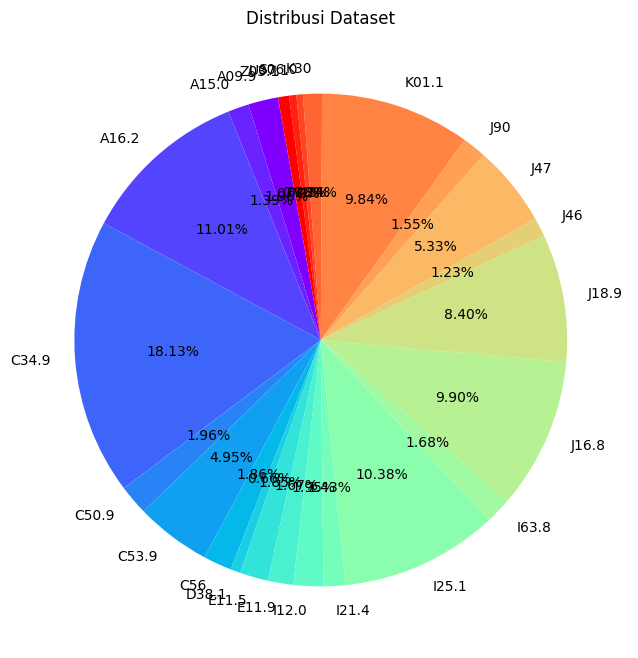

In [ ]:
#gabungkan data dari set yang ada dengan set hasil dari data frame baru
population = make_cumulative(maxfile)

#check visual hasil kumulasi
print("Kumulasi akhir")
my_pievisual(population,"Distribusi Dataset", 8, 8)

### encode Data

In [ ]:
#register code kedalam index, start from 0
label_encoder = reg_encoder(label_encoder)

for seq in range(1, maxfile) :
    #load data yang bersih
    dfclean = load_encode_clean_andsave(seq, label_encoder)


File  /content/drive/My Drive/files/single/dataset_ICD10[1].xlsx  Loaded


###histogram token


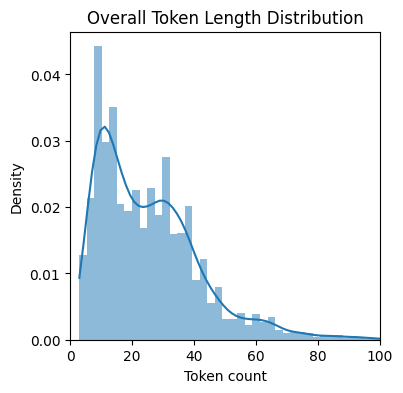

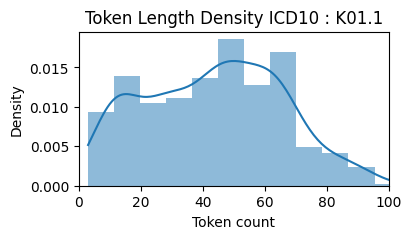

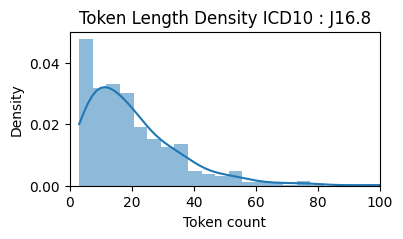

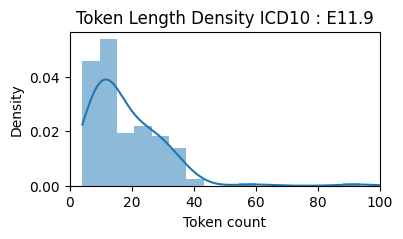

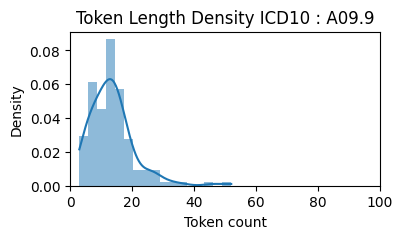

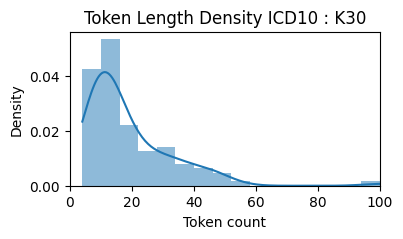

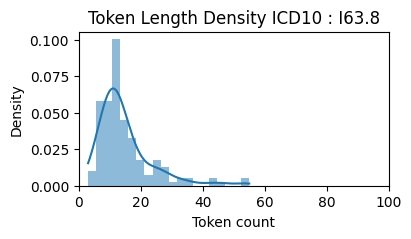

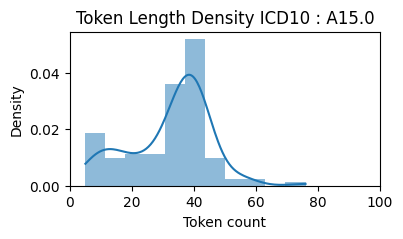

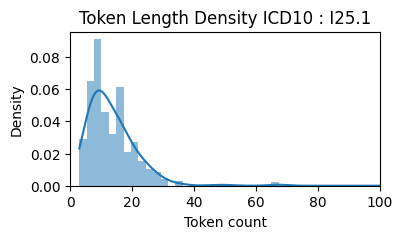

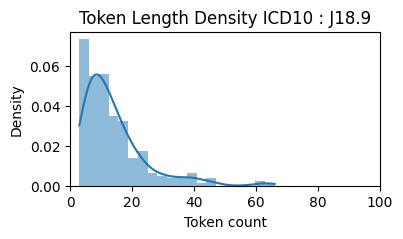

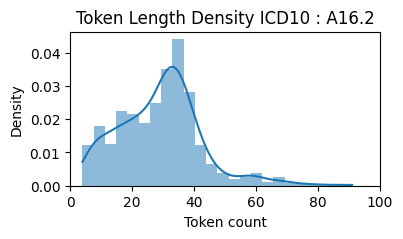

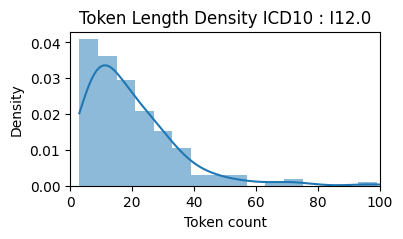

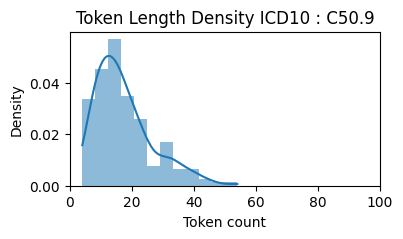

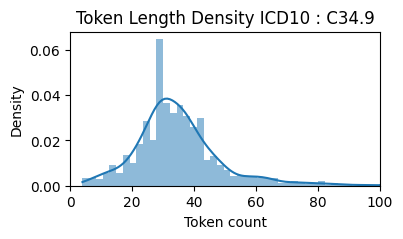

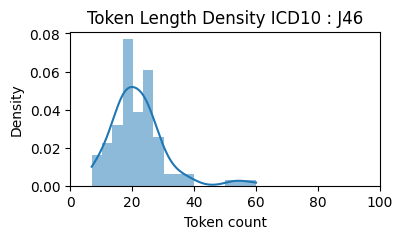

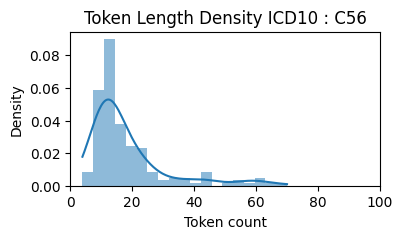

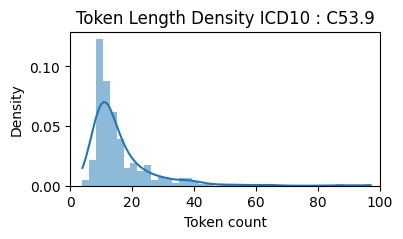

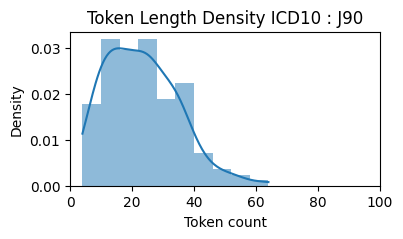

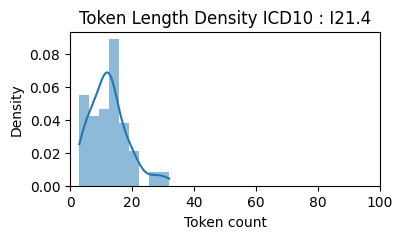

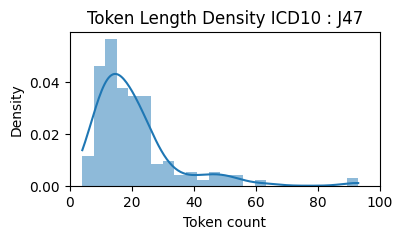

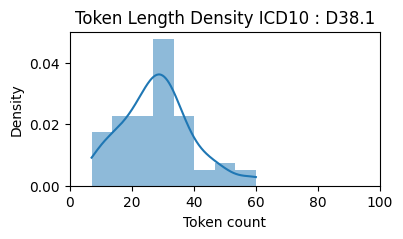

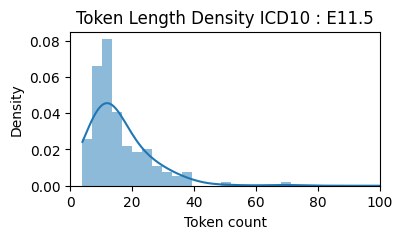

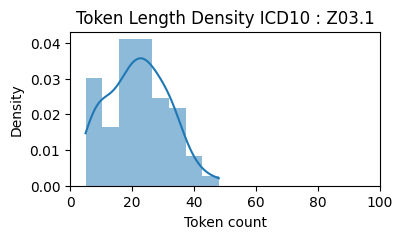

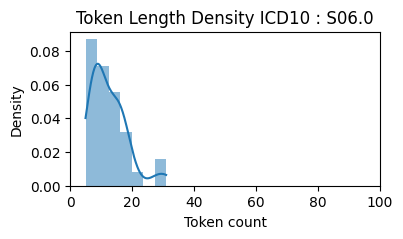

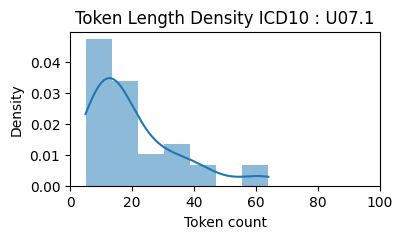

In [ ]:
histogram(tokenizer, label_encoder)

## check previous variable saved

In [ ]:
#Initialize lists to record metrics
avg_train_losses = []
avg_val_losses = []  #modification
train_precisions = []  #modification
train_recalls = []  #modification
train_f1_scores = []  #modification
val_precisions = []  #modification
val_recalls = []  #modification
val_f1_scores = []  #modification
learning_rates = []

#register code kedalam index, start from 0
label_encoder = reg_encoder(label_encoder)
epoch = 0  #additional

# Check if there is a saved training state
# matikan jika ingin benchmark hyper parameter
try:  #additional
    state = load_training_state(training_state)  #additional

    avg_train_losses = state['avg_train_losses']  #additional
    avg_val_losses = state['avg_val_losses']  #additional
    train_precisions = state['train_precisions']  #additional
    train_recalls = state['train_recalls']  #additional
    train_f1_scores = state['train_f1_scores']  #additional
    val_precisions = state['val_precisions']  #additional
    val_recalls = state['val_recalls']  #additional
    val_f1_scores = state['val_f1_scores']  #additional
    learning_rates = state['learning_rates']  #additional
    epoch = state['epoch']  #additional

    total_train_loss= state['total_train_loss']  #additional
    all_train_labels= state['all_train_labels']  #additional
    all_train_preds= state['all_train_preds']  #additional
    total_val_loss= state['total_val_loss']  #additional
    all_val_labels= state['all_val_labels']  #additional
    all_val_preds= state['all_val_preds']

except FileNotFoundError:  #additional
    epoch = 0  #additional



File  /content/drive/My Drive/files/single/dataset_ICD10[1].xlsx  Loaded


##training loop

In [ ]:
# Initialize an empty list to hold datasets
all_datasets = []
file_count = 0


# Load and concatenate datasets
for seq in range(1, maxfile):
    dfcleanload = load_encode_clean_andsave(seq, label_encoder)
    if dfcleanload is not False and not dfcleanload.empty:
        dataset = df_to_tensor_dataset(dfcleanload, tokenizer)
        all_datasets.append(dataset)
    file_count += 1

# Combine all individual datasets into one
dfclean = ConcatDataset(all_datasets)

train_size = int(0.70 * len(dfclean))  # 70% for training
val_size = int(0.2 * len(dfclean))    # 20% for validation
test_size = len(dfclean) - train_size - val_size  # 10% for testing
train_dataset, val_dataset, test_dataset = random_split(dfclean, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Training loop
while epoch < num_epochs:  #modification

    learning_rate =   init_rate

    total_train_loss = 0
    all_train_labels = []  #
    all_train_preds = []  #
    total_val_loss = 0  #
    all_val_labels = []  #
    all_val_preds = []  #

    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Collect all predictions and labels for this batch
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_train_preds.extend(preds)
        all_train_labels.extend(labels.cpu().numpy())

      # Validation
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()  #
            all_val_preds.extend(preds)  #
            all_val_labels.extend(labels.cpu().numpy())  #



    # Print training loss
    learning_rates.append(learning_rate)

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_losses.append(avg_train_loss)
    avg_val_loss = total_val_loss / len(val_loader)   #
    avg_val_losses.append(avg_val_loss)  #

    train_precision = precision_score(all_train_labels, all_train_preds, average='weighted', zero_division=1)
    train_recall = recall_score(all_train_labels, all_train_preds, average='weighted')
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')

    val_precision = precision_score(all_val_labels, all_val_preds, average='weighted', zero_division=1)  #
    val_recall = recall_score(all_val_labels, all_val_preds, average='weighted')  #
    val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')  #

    train_precisions.append(train_precision)  #
    train_recalls.append(train_recall)  #
    train_f1_scores.append(train_f1)  #
    val_precisions.append(val_precision)  #
    val_recalls.append(val_recall)  #
    val_f1_scores.append(val_f1)  #


    print(f'Epoch [{epoch+1}/{num_epochs}], L= {learning_rate:.6f} '
          f'Train Loss: {avg_train_loss:.4f}, '  #
          f'Train Precision: {train_precision:.4f}, '  #
          f'Train Recall: {train_recall:.4f}, '  #
          f'Train F1 Score: {train_f1:.4f}')  #

    print(f'Epoch [{epoch+1}/{num_epochs}], L= {learning_rate:.6f} '
          f' Val Loss: {avg_val_loss:.4f}, '  #
          f'Val Precision: {val_precision:.4f}, '  #
          f' Val Recall: {val_recall:.4f}, '  #
          f'Val F1 Score: {val_f1:.4f}')  #

    # Save training state at the end of each epoch  #
    save_training_state(training_state,  #
                        avg_train_losses=avg_train_losses,  #
                        avg_val_losses=avg_val_losses,  #
                        train_precisions=train_precisions,  #
                        train_recalls=train_recalls,  #
                        train_f1_scores=train_f1_scores,  #
                        val_precisions=val_precisions,  #
                        val_recalls=val_recalls,  #
                        val_f1_scores=val_f1_scores,  #
                        learning_rates=learning_rates,  #
                        epoch=epoch,  #
                        file_count=file_count,  #
                        total_train_loss=total_train_loss,  #
                        all_train_labels=all_train_labels,  #
                        all_train_preds=all_train_preds,  #
                        total_val_loss=total_val_loss,  #
                        all_val_labels=all_val_labels,  #
                        all_val_preds=all_val_preds)  #

    epoch += 1  #

# Model saving
save_model(model)


Epoch [1/60], L= 0.000100 Train Loss: 3.0380, Train Precision: 0.5666, Train Recall: 0.2461, Train F1 Score: 0.0996
Epoch [1/60], L= 0.000100  Val Loss: 2.9981, Val Precision: 0.8127,  Val Recall: 0.2496, Val F1 Score: 0.0997
Training state saved to nowtraining_state.pkl
Epoch [2/60], L= 0.000100 Train Loss: 2.9809, Train Precision: 0.7268, Train Recall: 0.2691, Train F1 Score: 0.1317
Epoch [2/60], L= 0.000100  Val Loss: 2.9065, Val Precision: 0.7741,  Val Recall: 0.3428, Val F1 Score: 0.1981
Training state saved to nowtraining_state.pkl
Epoch [3/60], L= 0.000100 Train Loss: 2.8956, Train Precision: 0.6497, Train Recall: 0.3536, Train F1 Score: 0.2299
Epoch [3/60], L= 0.000100  Val Loss: 2.8409, Val Precision: 0.7733,  Val Recall: 0.4054, Val F1 Score: 0.2699
Training state saved to nowtraining_state.pkl
Epoch [4/60], L= 0.000100 Train Loss: 2.8143, Train Precision: 0.7235, Train Recall: 0.4425, Train F1 Score: 0.3178
Epoch [4/60], L= 0.000100  Val Loss: 2.7771, Val Precision: 0.7661, 

## TEsting

In [ ]:
# Testing phase
model.eval()
total_test_loss = 0
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        total_test_loss += loss.item()

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_test_preds.extend(preds)
        all_test_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_precision = precision_score(all_test_labels, all_test_preds, average='weighted', zero_division=1)  #modification
test_recall = recall_score(all_test_labels, all_test_preds, average='weighted')  #modification
test_f1 = f1_score(all_test_labels, all_test_preds, average='weighted')  #modification

print(f'Test Accuracy: {test_accuracy:.4f}, '  #modification
      f'Test Precision: {test_precision:.4f}, '  #modification
      f' Test Recall: {test_recall:.4f}, '  #modification
      f'Test F1 Score: {test_f1:.4f}')  #modification


Test Accuracy: 0.6265, Test Precision: 0.7441,  Test Recall: 0.6265, Test F1 Score: 0.5356


#Draw Plot


## Graph Train loss, Recall, Precs, F1

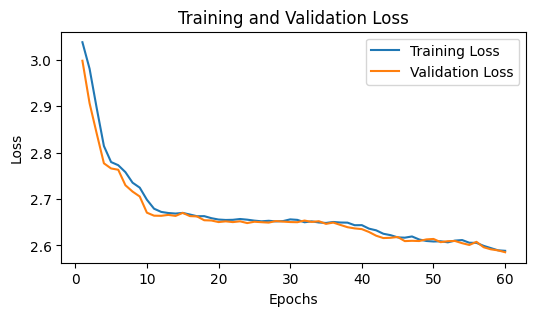

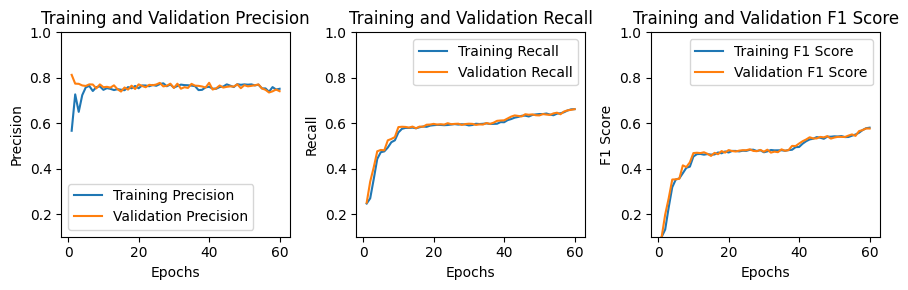

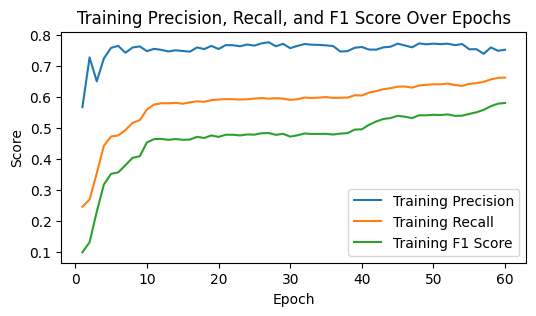

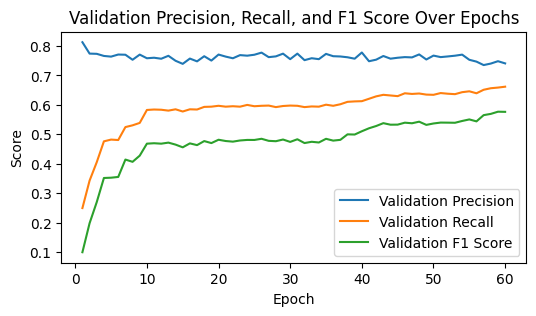

In [ ]:
#train_loss(num_epochs, avg_train_losses )
#all_f1(num_epochs, precisions, recalls, f1_scores)

train_loss(num_epochs, avg_train_losses, avg_val_losses)  #

all_f1(num_epochs, train_precisions, train_recalls, train_f1_scores, val_precisions, val_recalls, val_f1_scores)  #modification

all_train(num_epochs, train_precisions, train_recalls, train_f1_scores, val_precisions, val_recalls, val_f1_scores)


## Table  render

In [ ]:

# Render metrics in table form using Streamlit
# render_metrics_table(num_epochs, learning_rates, avg_train_losses, avg_val_losses,
#                      train_precisions, train_recalls, train_f1_scores, val_precisions,
#                      val_recalls, val_f1_scores)  #modification


html_metrics_table(num_epochs,learning_rates, avg_train_losses, avg_val_losses,
                   train_precisions, train_recalls, train_f1_scores, val_precisions,
                   val_recalls, val_f1_scores)  #modification




,Epoch,Learning Rate,Avg Training Loss,Avg Validation Loss,Train Precision,Val Precision,Train Recall,Val Recall,Train F1 Score,Val F1 Score
0,1,0.000100,3.0380,2.9981,0.5666,0.8127,0.2461,0.2496,0.0996,0.0997
1,2,0.000100,2.9809,2.9065,0.7268,0.7741,0.2691,0.3428,0.1317,0.1981
2,3,0.000100,2.8956,2.8409,0.6497,0.7733,0.3536,0.4054,0.2299,0.2699
3,4,0.000100,2.8143,2.7771,0.7235,0.7661,0.4425,0.4762,0.3178,0.3518
4,5,0.000100,2.7798,2.7660,0.7575,0.7638,0.4721,0.4821,0.3519,0.3527
5,6,0.000100,2.7730,2.7632,0.7639,0.7709,0.4757,0.4806,0.3567,0.3553
6,7,0.000100,2.7580,2.7298,0.7416,0.7702,0.4928,0.5246,0.3797,0.4143
7,8,0.000100,2.7353,2.7161,0.7587,0.7532,0.5162,0.5306,0.4036,0.4067
8,9,0.000100,2.7246,2.7055,0.7621,0.7707,0.5245,0.5387,0.4084,0.4276
9,10,0.000100,2.6986,2.6707,0.7468,0.7583,0.5590,0.5827,0.4531,0.4683


## confusion

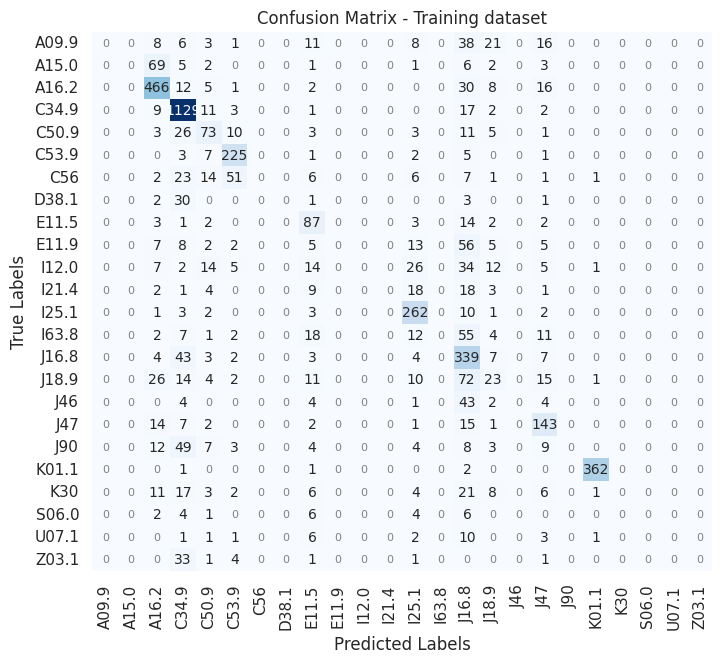

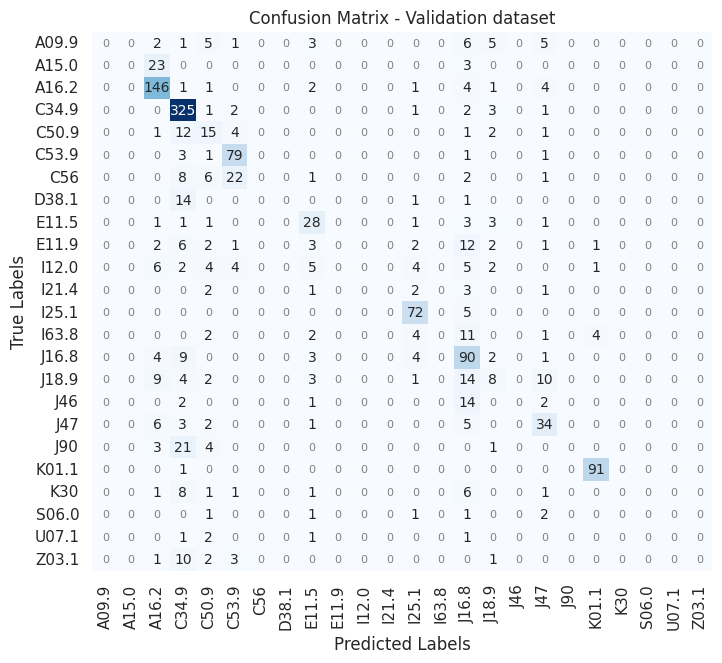

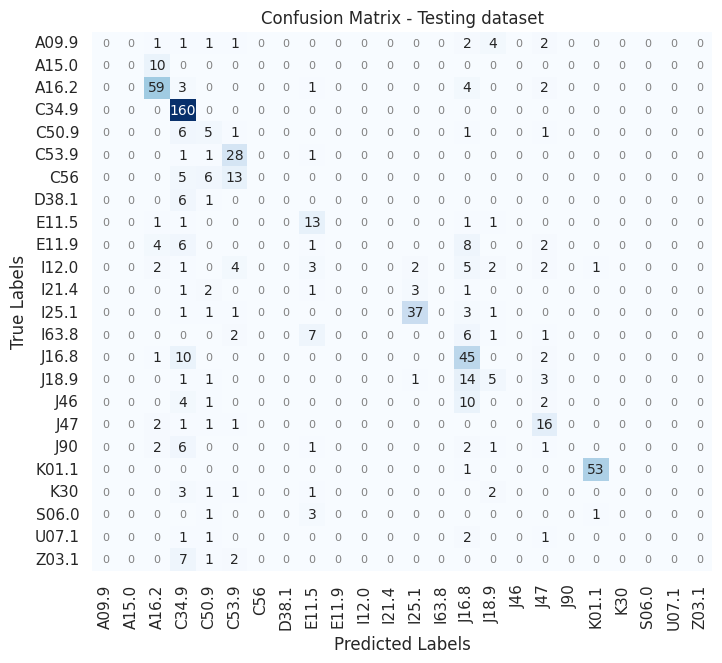

In [ ]:
unique_labels = list(label_encoder.classes_)  #additional
#unique_labels = list(range(len(label_encoder.classes_)))  #additional


# Filter labels to include only those present in predictions  #additional

unique_train_labels = [label for label in unique_labels if label_encoder.transform([label])[0] in all_train_labels]  #additional
unique_val_labels = [label for label in unique_labels if label_encoder.transform([label])[0] in all_val_labels]  #additional

#plot_confusion_matrix
ctrain = plot_confusion_matrix([label_encoder.inverse_transform([label])[0] for label in all_train_labels],
                      [label_encoder.inverse_transform([pred])[0] for pred in all_train_preds],
                      labels=unique_train_labels,title ='Confusion Matrix - Training dataset')  #additional

cvalid = plot_confusion_matrix([label_encoder.inverse_transform([label])[0] for label in all_val_labels],
                      [label_encoder.inverse_transform([pred])[0] for pred in all_val_preds],
                      labels=unique_val_labels,title ='Confusion Matrix - Validation dataset')  #additional

ctest = plot_confusion_matrix([label_encoder.inverse_transform([label])[0] for label in all_test_labels],
                      [label_encoder.inverse_transform([pred])[0] for pred in all_test_preds],
                      labels=unique_val_labels,title ='Confusion Matrix - Testing dataset')  #additional


In [ ]:
display(ctrain)


,precision,recall,f1_score
A09.9,0.000000,0.000000,0.000000
A15.0,0.000000,0.000000,0.000000
A16.2,0.716923,0.862963,0.783193
C34.9,0.790063,0.961670,0.867461
C50.9,0.450617,0.540741,0.491582
C53.9,0.716561,0.922131,0.806452
C56,0.000000,0.000000,0.000000
D38.1,0.000000,0.000000,0.000000
E11.5,0.422330,0.763158,0.543750
E11.9,0.000000,0.000000,0.000000


In [ ]:
display(cvalid)

,precision,recall,f1_score
A09.9,0.000000,0.000000,0.000000
A15.0,0.000000,0.000000,0.000000
A16.2,0.712195,0.912500,0.800000
C34.9,0.752315,0.970149,0.847458
C50.9,0.277778,0.416667,0.333333
C53.9,0.675214,0.929412,0.782178
C56,0.000000,0.000000,0.000000
D38.1,0.000000,0.000000,0.000000
E11.5,0.500000,0.717949,0.589474
E11.9,0.000000,0.000000,0.000000


In [ ]:

display(ctest);

,precision,recall,f1_score
A09.9,0.000000,0.000000,0.000000
A15.0,0.000000,0.000000,0.000000
A16.2,0.719512,0.855072,0.781457
C34.9,0.711111,1.000000,0.831169
C50.9,0.208333,0.357143,0.263158
C53.9,0.518519,0.903226,0.658824
C56,0.000000,0.000000,0.000000
D38.1,0.000000,0.000000,0.000000
E11.5,0.406250,0.764706,0.530612
E11.9,0.000000,0.000000,0.000000
